In [ ]:
import pandas as pd
import numpy as np
import pickle
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import random
from sklearn.metrics import pairwise_distances_argmin_min

#set font size of labels on matplotlib plots
plt.rc('font', size=16)

#set style of plots
sns.set_style('white')

#define a custom palette
sns.palplot(sns.color_palette("hls", 8))

In [2]:
df = pd.read_pickle('../players/player_stats.pkl')

In [3]:
df.head()

,Player,G,GS,MP,FG,FGA,FG%,2P,2PA,2P%,...,TOV,PF,PTS,ORtg,DRtg,Team,Season,Class,Pos,Height
0,Julian Edmonson,30,5.0,568,10.5,26.2,0.401,6.2,15.2,0.411,...,5.6,6.6,34.5,102.3,107.9,abilene-christian,2014,1.0,G,73.0
1,Jacob Lancaster,31,11.0,434,12.0,21.7,0.553,11.8,21.5,0.551,...,5.6,6.7,29.1,102.9,99.3,abilene-christian,2014,1.0,F,82.0
2,Parker Wentz,31,29.0,1040,7.7,15.7,0.491,3.2,5.6,0.576,...,3.4,4.0,24.5,124.7,107.5,abilene-christian,2014,1.0,G,69.0
3,LaDarrien Williams,16,14.0,474,8.1,21.8,0.371,6.4,16.3,0.389,...,4.2,5.2,24.4,101.2,104.1,abilene-christian,2014,1.0,G,72.0
4,Harrison Hawkins,16,16.0,481,6.8,18.1,0.374,3.7,10.4,0.353,...,6.0,5.8,24.1,100.9,108.5,abilene-christian,2014,1.0,G,72.0


## Functions

In [4]:
def guards(df):
    df = df[df['Pos'] == 'G']
    return df

In [5]:
def forwards(df):
    df = df[df['Pos'] == 'F']
    return df

In [6]:
def centers(df):
    df = df[df['Pos'] == 'C']
    return df

In [7]:
def drop_cols(df):
    df = df.drop(['G', 'GS', 'MP'], axis=1)
    return df

In [8]:
def players2018(df):
    df = df[df['Season'] == 2018]
    return df

In [9]:
def cluster_matrix_reduced(df):
#     df = df.iloc[:, 0:25]
    player = df['Player'].as_matrix()
    position = df['Pos'].as_matrix()
    X_r = df.iloc[:, 1:].drop(['Season', 'Team', 'Pos', 'FG%', '2P%', '3P%', 'FT%', 'PF', 'Height', 'Class', 'FGA', 'FG', '2PA', '3PA', 'FT', 'FTA', 'ORtg', 'DRtg', '2P'], axis=1).as_matrix()
    return X_r, player, position

In [10]:
def ID(row):
    row['ID'] = ",".join([row['Team'], str(row['Season'])])
    return row

In [11]:
def map_pos(df):
    pos_dict = {'G': 'G', 'PG': 'G', 'SG': 'G', 'F': 'F', 'SF': 'F', 'PF': 'F', 'C': 'C'}
    df['Pos'] = df['Pos'].map(pos_dict)
    return df

## Roster Counts

In [12]:
df = map_pos(df)

In [13]:
df.Pos.value_counts()

G    13324
F     8508
C     1480
Name: Pos, dtype: int64

In [14]:
df.dropna().Pos.value_counts()

G    11381
F     5600
C      489
Name: Pos, dtype: int64

In [15]:
def team_player_counts(df):
    team_player_counts = df[['Player', 'Pos', 'Team', 'Season']]
    team_player_counts = pd.pivot_table(team_player_counts, index=['Team', 'Season', 'Pos'], aggfunc='count')
    team_player_counts = team_player_counts.reset_index()
    team_player_counts.columns = ['Team', 'Season', 'Pos', 'Player_Count']
    return team_player_counts

In [16]:
team_player_counts = team_player_counts(df)

In [17]:
team_player_counts.head()

,Team,Season,Pos,Player_Count
0,abilene-christian,2014,F,5
1,abilene-christian,2014,G,7
2,abilene-christian,2015,F,5
3,abilene-christian,2015,G,9
4,abilene-christian,2016,F,5


In [18]:
df2018 = players2018(df)

In [19]:
df2018.groupby('Pos').mean()

,G,GS,MP,FG,FGA,FG%,2P,2PA,2P%,3P,...,STL,BLK,TOV,PF,PTS,ORtg,DRtg,Season,Class,Height
Pos,,,,,,,,,,,,,,,,,,,,,
C,24.617188,11.214844,382.992188,6.950391,13.555469,0.525565,6.680859,12.610938,0.541125,0.269922,...,0.990625,2.808984,3.675781,8.706250,17.417969,102.475391,102.467969,2018.0,0.796875,82.187500
F,25.695214,12.590050,475.289673,6.887028,14.667632,0.470782,5.729786,10.967947,0.516275,1.156108,...,1.376763,1.645529,3.462217,7.107053,18.460202,102.319018,103.553589,2018.0,0.726700,79.594458
G,25.249795,13.242412,558.977030,6.275267,15.991017,0.392270,3.779614,8.270919,0.449407,2.495939,...,1.920837,0.394011,3.661567,4.715997,18.447621,98.706932,105.967473,2018.0,0.726415,74.596390


## Reduced DateFrame

In [20]:
# Features to Cluster Centers
reduced_df_cols = ['Player', 'MP', 'FT', '2P', '3P', 'TRB', 'AST', 'STL',
                     'BLK', 'PTS', 'Team', 'Season', 'Pos']

# ['Player', 'MP', 'FT', 'FTA', 'FT%', '2P', '2PA', '2P%', '3P', '3PA', '3P%', 'TRB', 'AST', 'STL',
#                      'BLK', 'TOV', 'PTS', 'Team', 'Season', 'Pos', 'Height']

df_r = df[reduced_df_cols]

c_reduced_df_cols = ['Player', 'MP', '2P', '3P', 'TRB', 'AST', 'STL',
                     'BLK', 'TOV', 'PTS', 'Team', 'Season', 'Pos', 'Height']

c_df_r = df[c_reduced_df_cols]

# Features to Cluster Forwards
f_reduced_df_cols = ['Player', 'MP', '2P', '2PA', '3P', '3PA', 'TRB', 'AST', 'STL',
                     'BLK', 'TOV', 'PTS', 'Team', 'Season', 'Pos']

f_df_r = df[f_reduced_df_cols]

# Features to Cluster Guards
g_reduced_df_cols = ['Player', 'MP', '3P', 'AST', 'STL', 'TOV',
                     'PTS', 'TRB', 'Team', 'Season', 'Pos']

g_df_r = df[g_reduced_df_cols]

## Deal with NaNs

In [21]:
# Drop NaNs from reduced DataFrame
df_r.Pos.value_counts()

G    13324
F     8508
C     1480
Name: Pos, dtype: int64

In [22]:
df_r.dropna().Pos.value_counts()

G    13270
F     8461
C     1475
Name: Pos, dtype: int64

In [23]:
# Drop NaNs from reduced DataFrame
df_r = df_r.dropna()
c_df_r = centers(c_df_r.dropna())
g_df_r = guards(g_df_r.dropna())
f_df_r = forwards(f_df_r.dropna())

## Vectorize dfs

In [24]:
def cluster_matrix(df):
    player = df['Player'].as_matrix()
    position = df['Pos'].as_matrix()
    X = df.drop(['Player', 'MP', 'Team', 'Season', 'Pos'], axis=1).as_matrix()
    return X, player, position

In [25]:
X, player, position = cluster_matrix(df_r)
X_c, player_c, position_c = cluster_matrix(c_df_r)
X_f, player_f, position_f = cluster_matrix(f_df_r)
X_g, player_g, position_g = cluster_matrix(g_df_r)

In [26]:
X_cols = df_r.drop(['Player', 'MP', 'Team', 'Season', 'Pos'], axis=1).columns.tolist()
X_c_cols = c_df_r.drop(['Player', 'MP', 'Team', 'Season', 'Pos'], axis=1).columns.tolist()
X_f_cols = f_df_r.drop(['Player', 'MP', 'Team', 'Season', 'Pos'], axis=1).columns.tolist()
X_g_cols = g_df_r.drop(['Player', 'MP', 'Team', 'Season', 'Pos'], axis=1).columns.tolist()

## Standardize

In [27]:
scale = StandardScaler()
X = scale.fit_transform(X)
X_c = scale.fit_transform(X_c)
X_f = scale.fit_transform(X_f)
X_g = scale.fit_transform(X_g)

In [28]:
# scale = StandardScaler()
# X_f = scale.fit_transform(X_f)

In [29]:
# scale = StandardScaler()
# X_g = scale.fit_transform(X_g)

## Cluster

In [30]:
Ks = range(2, 10, 1)
km = [KMeans(n_clusters=i) for i in Ks]
sil_score = [silhouette_score(X, km[i].fit(X).labels_) for i in range(len(km))]
sil_score_c = [silhouette_score(X_c, km[i].fit(X_c).labels_) for i in range(len(km))]
sil_score_f = [silhouette_score(X_f, km[i].fit(X_f).labels_) for i in range(len(km))]
sil_score_g = [silhouette_score(X_g, km[i].fit(X_g).labels_) for i in range(len(km))]

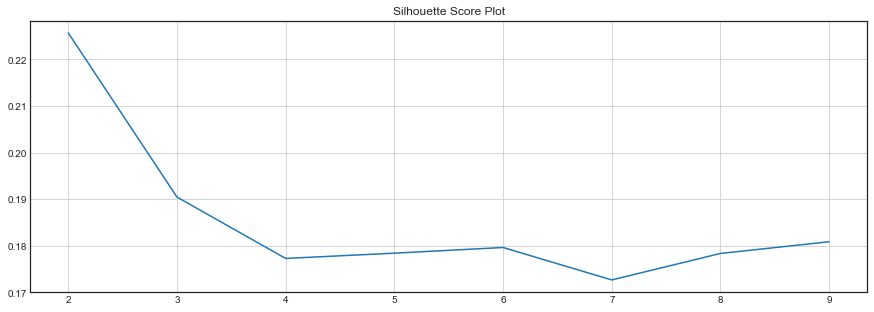

In [31]:
fig = plt.figure(figsize=(15, 5))
plt.plot(Ks, sil_score)
plt.grid(True)
plt.title('Silhouette Score Plot');

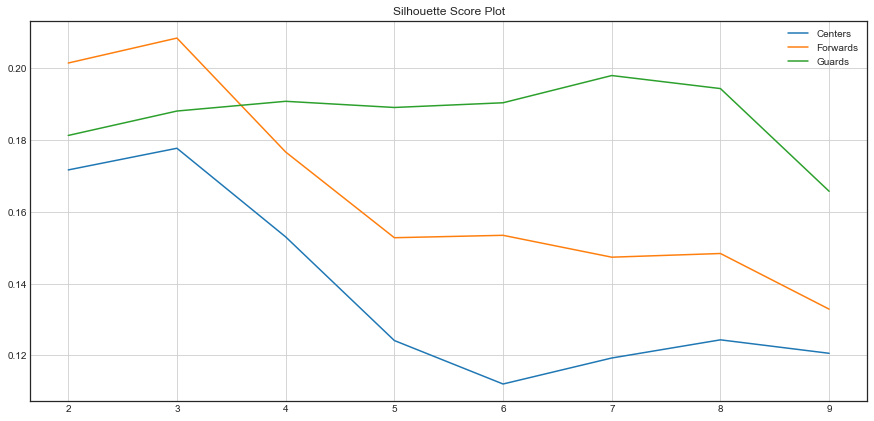

In [32]:
fig = plt.figure(figsize=(15, 7))
plt.plot(Ks, sil_score_c)
plt.plot(Ks, sil_score_f)
plt.plot(Ks, sil_score_g)
plt.legend(['Centers', 'Forwards', 'Guards'], loc='best')
plt.grid(True)
plt.title('Silhouette Score Plot');

In [33]:
ckmeans = KMeans(n_clusters=3, init='k-means++', n_init=20, max_iter=500, tol=0.0001,
                        precompute_distances='auto', verbose=0, random_state=None,
                        copy_x=True, n_jobs=-1, algorithm='auto')
ckmeans.fit(X_c);

In [34]:
fkmeans = KMeans(n_clusters=3, init='k-means++', n_init=20, max_iter=500, tol=0.0001,
                        precompute_distances='auto', verbose=0, random_state=None,
                        copy_x=True, n_jobs=-1, algorithm='auto')
fkmeans.fit(X_f);

In [60]:
gkmeans = KMeans(n_clusters=7, init='k-means++', n_init=20, max_iter=500, tol=0.0001,
                        precompute_distances='auto', verbose=0, random_state=None,
                        copy_x=True, n_jobs=-1, algorithm='auto')
gkmeans.fit(X_g);

In [61]:
cclusters = ckmeans.labels_
ccluster_centers = ckmeans.cluster_centers_ 
fclusters = fkmeans.labels_
fcluster_centers = fkmeans.cluster_centers_ 
gclusters = gkmeans.labels_
gcluster_centers = gkmeans.cluster_centers_ 

In [37]:
#sorting to get top 10 feature indexes for each centroid
ccluster_ind = np.argsort(ccluster_centers, axis=1)
top = 3
tops = np.array([])
for row in ccluster_ind[:,:top]:
    cluster_tops = np.array([])
    for col in row:
        cluster_tops = np.append(cluster_tops, X_c_cols[col])
    tops = np.append(tops, cluster_tops)

tops.reshape(-1,top)

array([['TRB', 'BLK', 'Height'],
       ['PTS', '2P', 'TRB'],
       ['3P', 'Height', 'BLK']], dtype='<U32')

In [38]:
#sorting to get top 10 feature indexes for each centroid
fcluster_ind = np.argsort(fcluster_centers, axis=1)
top = 3
tops = np.array([])
for row in ccluster_ind[:,:top]:
    cluster_tops = np.array([])
    for col in row:
        cluster_tops = np.append(cluster_tops, X_f_cols[col])
    tops = np.append(tops, cluster_tops)

tops.reshape(-1,top)

array([['3P', 'AST', 'TOV'],
       ['BLK', '2P', '3P'],
       ['2PA', 'TOV', 'AST']], dtype='<U32')

In [94]:
#sorting to get top 10 feature indexes for each centroid
gcluster_ind = np.argsort(gcluster_centers, axis=1)
top = 3
tops = np.array([])
for row in gcluster_ind[:,:top]:
    cluster_tops = np.array([])
    for col in row:
        cluster_tops = np.append(cluster_tops, X_g_cols[col])
    tops = np.append(tops, cluster_tops)

tops.reshape(-1,top)

array([['3P', 'TRB', 'PTS'],
       ['AST', 'TOV', 'TRB'],
       ['PTS', '3P', 'AST'],
       ['3P', 'TRB', 'PTS'],
       ['AST', 'STL', 'TRB'],
       ['3P', 'AST', 'PTS'],
       ['PTS', '3P', 'STL']], dtype='<U32')

In [40]:
pd.DataFrame(ccluster_centers, columns=X_c_cols)

,2P,3P,TRB,AST,STL,BLK,TOV,PTS,Height
0,-0.333492,3.244333,-0.597639,1.006431,0.118459,-0.547968,-0.135974,0.659963,-0.532631
1,-0.639324,-0.228839,-0.286592,-0.271048,-0.144797,-0.012541,-0.081994,-0.699652,-0.012602
2,0.889021,-0.158310,0.462012,0.214302,0.173868,0.094141,0.127222,0.827713,0.092049


In [41]:
pd.DataFrame(fcluster_centers, columns=X_f_cols)

,2P,2PA,3P,3PA,TRB,AST,STL,BLK,TOV,PTS
0,-0.590058,-0.601045,1.387023,1.431956,-0.506922,0.321159,0.042777,-0.439382,-0.182442,0.308397
1,-0.559597,-0.500337,-0.463489,-0.443985,-0.147651,-0.254786,-0.124790,0.014963,-0.159108,-0.830906
2,0.964038,0.906883,-0.348678,-0.397181,0.469168,0.078217,0.108347,0.252585,0.283074,0.707008


In [63]:
pd.DataFrame(gcluster_centers, columns=X_g_cols)

,3P,AST,STL,TOV,PTS,TRB
0,-0.354651,1.216028,0.271750,0.262282,-0.103118,-0.172579
1,0.671806,-0.233184,-0.063284,-0.132763,0.591272,-0.122013
2,-0.570581,-0.479075,-0.196490,-0.168544,-0.805399,-0.321392
3,-1.111836,0.694024,15.650179,0.760368,0.355788,0.106601
4,4.796622,-0.620723,-0.399093,0.204643,3.180207,0.182637
5,-0.653495,-0.485090,-0.021183,0.069897,-0.071189,1.788490
6,-0.965928,-0.221978,-0.829226,12.470603,-1.388813,1.127336


In [43]:
topics = c_df_r.Player
for clust in np.unique(ckmeans.labels_):
    mask = ckmeans.labels_ == clust
    print('Cluster {}: {}\n'.format(clust, random.sample(list(topics[mask]), 10)))

Cluster 0: ['Brendan Leonard', 'Tyler Hadden', 'Corey Young', 'Jalone Friday', 'Luke Kornet', 'Rauno Nurger', 'Cory Osetkowski', 'Will Childs-Klein', 'Nate Fowler', 'James Ringholt']

Cluster 1: ['Aaron Geramipoor', 'Daniel Giddens', 'Blaise Mbargorba', 'Eric Truog', 'Jordan Dickerson', 'Dominic Nelson', 'Matt Neufeld', 'Ivo Basor', 'Ivan Cucak', 'Bakary Konate']

Cluster 2: ['Rickey Brice Jr.', 'RJ White', 'Jaleel Roberts', 'Mike Thorne', 'Jaleel Cousins', 'Egidijus Mockevicius', 'James Stawarz', 'Matt Hodgson', 'Jon Teske', 'Tyere Marshall']



In [44]:
topics = f_df_r.Player
for clust in np.unique(fkmeans.labels_):
    mask = fkmeans.labels_ == clust
    print('Cluster {}: {}\n'.format(clust, random.sample(list(topics[mask]), 10)))

Cluster 0: ['Chris Jones', 'Roderick Perkins', 'Jake Flaggert', 'Dillon Brooks', 'Stephon Jelks', 'Blake Danielak', 'Kellen McCormick', 'Orlando Coleman', 'Thomas Ryan', 'Seth Towns']

Cluster 1: ['Michael Johnson', 'Jack Parsley', 'Aaron Rohlman', 'Junior Etou', 'Josh Ferguson', 'Zachary Reynolds', 'Shawn Ray', 'Daniel Broughton', 'Levan Shengelia', 'Clayton Crawford']

Cluster 2: ['Lis Shoshi', 'Chris Kemp', 'Michael Young', 'Kyle Ingram', 'Troy Williams', 'Hasahn French', 'Ashton Pankey', 'Jakeenan Gant', 'Nolan Narain', 'Nick Hornsby']



In [45]:
topics = g_df_r.Player
for clust in np.unique(gkmeans.labels_):
    mask = gkmeans.labels_ == clust
    print('Cluster {}: {}\n'.format(clust, random.sample(list(topics[mask]), 10)))

Cluster 0: ['Jalen Lindsey', 'Tucker Haymond', 'Jackson Donahue', 'Jalen Rhea', 'Demontrae Jefferson', 'Deuce Bello', 'Drew Charles', 'Patrick Rooks', 'Jesse Reed', 'Detrick Mostella']

Cluster 1: ['LeRon Barnes', 'Desmar Jackson', 'Chase Cannon', 'Haboubacar Mutombo', 'Lexx Edwards', 'Keshawn Liggins', 'Greg Heckstall', 'Chris Thomas', 'Tevonn Walker', 'Kortrijk Miles']

Cluster 2: ['Idris Taqqee', 'Nelly Cummings', 'Gerald Smith', 'Jacob Casper', 'Kevin Lynch', 'Troy Whiteside', 'Larry Austin', 'Manu Giamoukis', 'Crew Ainge', 'Vontay Ott']

Cluster 3: ['Jordan Borucki', 'Jalen McCallum', 'Mike Fernandez', 'Julian Robertson', 'Brett Paul', 'Christian Vega', 'John Yi', 'Andrew Leone', 'Keith Oddo', 'Benjamin James']

Cluster 4: ['ZaQwaun Matthews', "Jovante' Spivey", 'Cameron Fowler', 'Roddy Peters', 'Kevin Canevari', 'Richaud Gittens', 'Riley LaChance', 'Tyler Ailshie', 'Dikymbe Martin', 'Dylan Ennis']

Cluster 5: ['Peyton Robbins', 'Thomas Fleming', 'L.J. Thorpe', 'Mark Noble', 'Patr

## Just 2018

In [46]:
df2018 = players2018(df)

In [49]:
c_df2018 = centers(df2018)
f_df2018 = forwards(df2018)
g_df2018 = guards(df2018)

In [50]:
# Features to Cluster Centers
reduced_df2018_cols = ['Player', 'MP', 'FT', '2P', '3P', 'TRB', 'AST', 'STL',
                     'BLK', 'PTS', 'Team', 'Season', 'Pos']

df2018_r = df[reduced_df_cols]

c_reduced_df2018_cols = ['Player', 'MP', '2P', '3P', 'TRB', 'AST', 'STL',
                     'BLK', 'TOV', 'PTS', 'Team', 'Season', 'Pos', 'Height']

c_df2018_r = df[c_reduced_df_cols]

# Features to Cluster Forwards
f_reduced_df2018_cols = ['Player', 'MP', '2P', '2PA', '3P', '3PA', 'TRB', 'AST', 'STL',
                     'BLK', 'TOV', 'PTS', 'Team', 'Season', 'Pos']

f_df2018_r = df[f_reduced_df_cols]

# Features to Cluster Guards
g_reduced_df2018_cols = ['Player', 'MP', '3P', 'AST', 'STL', 'TOV',
                     'PTS', 'TRB', 'Team', 'Season', 'Pos']

g_df2018_r = df[g_reduced_df_cols]

In [51]:
# Drop NaNs from reduced DataFrame
df2018_r = df2018_r.dropna()
c_df2018_r = centers(c_df2018_r.dropna())
g_df2018_r = guards(g_df2018_r.dropna())
f_df2018_r = forwards(f_df2018_r.dropna())

In [54]:
X2018, player2018, position2018 = cluster_matrix(df2018_r)
X2018_c, player2018_c, position2018_c = cluster_matrix(c_df2018_r)
X2018_f, player2018_f, position2018_f = cluster_matrix(f_df2018_r)
X2018_g, player2018_g, position2018_g = cluster_matrix(g_df2018_r)

In [55]:
X2018_cols = df2018_r.drop(['Player', 'MP', 'Team', 'Season', 'Pos'], axis=1).columns.tolist()
X2018_c_cols = c_df2018_r.drop(['Player', 'MP', 'Team', 'Season', 'Pos'], axis=1).columns.tolist()
X2018_f_cols = f_df2018_r.drop(['Player', 'MP', 'Team', 'Season', 'Pos'], axis=1).columns.tolist()
X2018_g_cols = g_df2018_r.drop(['Player', 'MP', 'Team', 'Season', 'Pos'], axis=1).columns.tolist()

In [56]:
scale = StandardScaler()
X2018 = scale.fit_transform(X2018)
X2018_c = scale.fit_transform(X2018_c)
X2018_f = scale.fit_transform(X2018_f)
X2018_g = scale.fit_transform(X2018_g)

In [57]:
Ks = range(2, 10, 1)
km = [KMeans(n_clusters=i) for i in Ks]
sil_score2018 = [silhouette_score(X2018, km[i].fit(X2018).labels_) for i in range(len(km))]
sil_score_c2018 = [silhouette_score(X2018_c, km[i].fit(X2018_c).labels_) for i in range(len(km))]
sil_score_f2018 = [silhouette_score(X2018_f, km[i].fit(X2018_f).labels_) for i in range(len(km))]
sil_score_g2018 = [silhouette_score(X2018_g, km[i].fit(X2018_g).labels_) for i in range(len(km))]

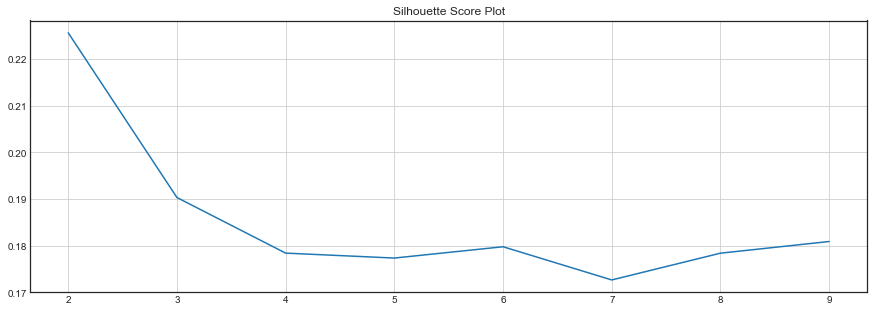

In [58]:
fig = plt.figure(figsize=(15, 5))
plt.plot(Ks, sil_score2018)
plt.grid(True)
plt.title('Silhouette Score Plot');

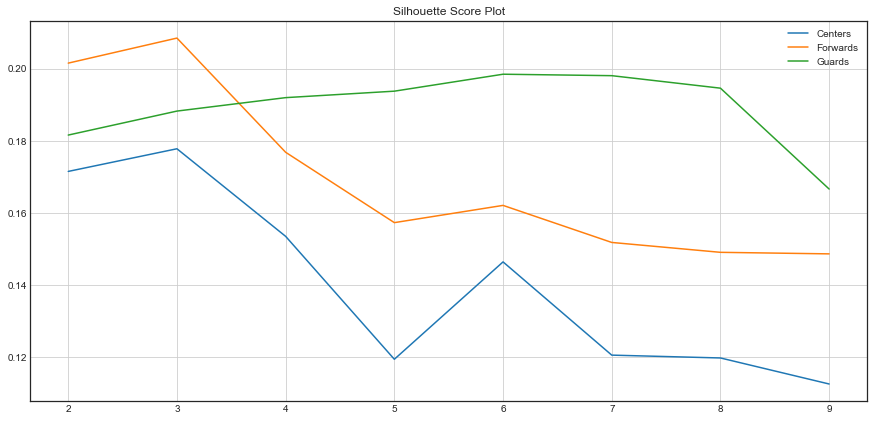

In [59]:
fig = plt.figure(figsize=(15, 7))
plt.plot(Ks, sil_score_c2018)
plt.plot(Ks, sil_score_f2018)
plt.plot(Ks, sil_score_g2018)
plt.legend(['Centers', 'Forwards', 'Guards'], loc='best')
plt.grid(True)
plt.title('Silhouette Score Plot');

## Forget about 2018

In [67]:
tSNE = TSNE(n_components=2)
X_c_tSNE = tSNE.fit_transform(X_c)
X_f_tSNE = tSNE.fit_transform(X_f)
X_g_tSNE = tSNE.fit_transform(X_g)

In [68]:
X_c_df = pd.DataFrame(X_c_tSNE, columns=['x','y'])
X_f_df = pd.DataFrame(X_f_tSNE, columns=['x','y'])
X_g_df = pd.DataFrame(X_g_tSNE, columns=['x','y'])

In [69]:
X_c_df['label'] = cclusters
X_f_df['label'] = fclusters
X_g_df['label'] = gclusters

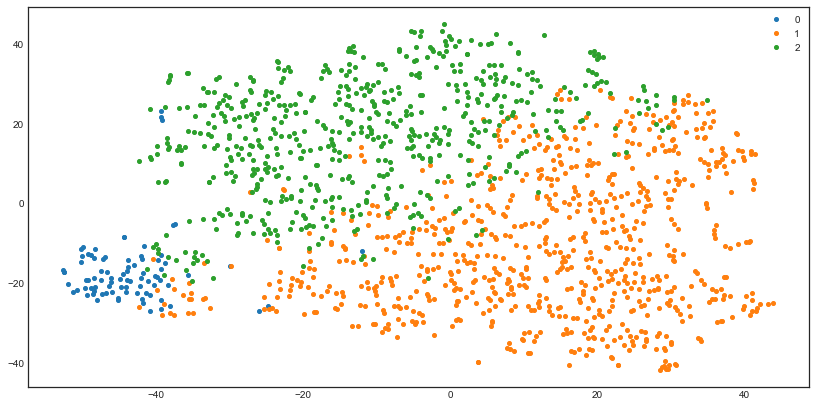

In [70]:
fig = plt.figure(figsize=(14,7))
ax = fig.add_subplot(111)

groups = X_c_df.groupby('label')

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=4, label=name)
ax.legend()

plt.show()

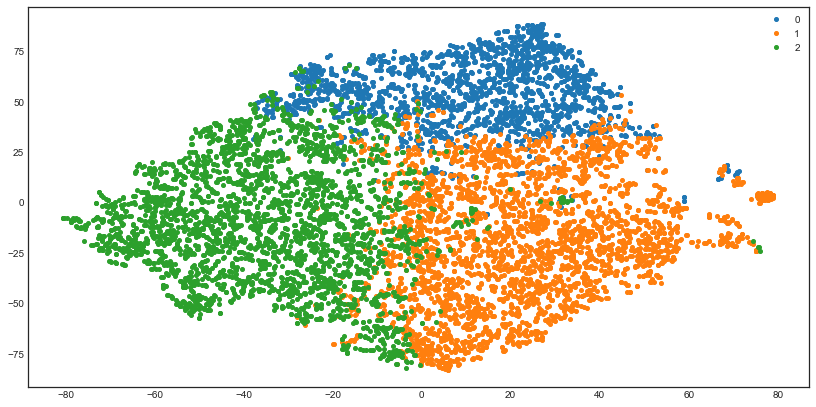

In [71]:
fig = plt.figure(figsize=(14,7))
ax = fig.add_subplot(111)

groups = X_f_df.groupby('label')

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=4, label=name)
ax.legend()

plt.show()

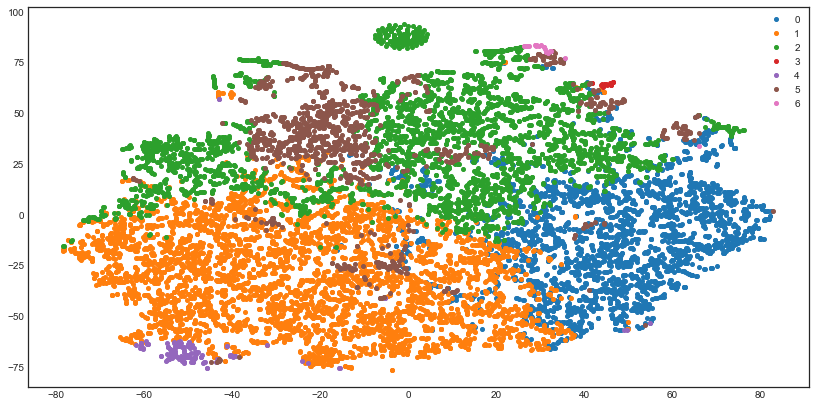

In [72]:
fig = plt.figure(figsize=(14,7))
ax = fig.add_subplot(111)

groups = X_g_df.groupby('label')

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=4, label=name)
ax.legend()

plt.show()

In [120]:
tSNE3 = TSNE(n_components=3)
X_c_tSNE3 = tSNE3.fit_transform(X_c)
X_f_tSNE3 = tSNE3.fit_transform(X_f)
X_g_tSNE3 = tSNE3.fit_transform(X_g)

In [ ]:
X3_c_df = pd.DataFrame(X_c_tSNE3, columns=['x', 'y', 'z'])
X3_f_df = pd.DataFrame(X_f_tSNE3, columns=['x', 'y', 'z'])
X3_g_df = pd.DataFrame(X_g_tSNE3, columns=['x', 'y', 'z'])

X3_c_df['label'] = cclusters
X3_f_df['label'] = fclusters
X3_g_df['label'] = gclusters

In [ ]:
def tSNE_3dscatter(df, title):
#     tSNE = TSNE(n_components=3) 
#     X_tSNE = tSNE.fit_transform(X)
    fig = plt.figure(figsize=(14,10))
    ax1 = fig.add_subplot(111,projection='3d')
    
#     df = pd.DataFrame(X_tSNE, columns=['x','y', 'z'])
#     df['label'] = labels
    groups = df.groupby('label')
    for name, group in groups:
        ax1.scatter(group.x, group.y, group.z, label=name)
    ax1.legend(loc='best')
    
#     ax2 = fig.add_subplot(122,projection='3d')
#     for name, group in groups:
#         ax2.scatter(group.x, group.y, group.z, label=name)
#     ax2.view_init(azim=30)
#     ax2.legend(loc='best')
    
    plt.title('{}: 3-Dimensional tSNE Plot'.format(title))

In [ ]:
tSNE_3dscatter(X3_c_df, 'Center Clusters')

In [ ]:
tSNE_3dscatter(X3_f_df, 'Forward Clusters')

In [ ]:
tSNE_3dscatter(X3_g_df, 'Guard Clusters')

In [ ]:
def tSNE_3dscatter_view(df, title):
#     tSNE = TSNE(n_components=3) 
#     X_tSNE = tSNE.fit_transform(X)
    fig = plt.figure(figsize=(14,10))
    ax1 = fig.add_subplot(111,projection='3d')
    
#     df = pd.DataFrame(X_tSNE, columns=['x','y', 'z'])
#     df['label'] = labels
    groups = df.groupby('label')
    for name, group in groups:
        ax1.scatter(group.x, group.y, group.z, label=name)
    ax1.view_init(azim=30)
    ax1.legend(loc='best')
    
    plt.title('{}: 3-Dimensional tSNE Plot'.format(title))

In [ ]:
tSNE_3dscatter_view(X3_c_df, 'Center Clusters')

In [ ]:
tSNE_3dscatter_view(X3_f_df, 'Forward Clusters')

In [ ]:
tSNE_3dscatter_view(X3_g_df, 'Guard Clusters')

## Cluster Representatives

In [ ]:
def centroid_rep(X, y):
    return pairwise_distances_argmin_min(X, y)

In [ ]:
centroid_rep(X_c, ccluster_centers)